<a href="https://colab.research.google.com/github/jupastro/CNNs/blob/main/Denoising_as_the_pretext_task_for_mitochondria_segmentation_(TF2)_over_different_of_annotated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising example: U-Net-like architecture for mitochondria segmentation in 2D

---
## Introduction
This notebook aims at being a playground to study U-Net-like architectures for semantic segmentation in 2D as well as the use of Self-Supervised Learning(SSL) pre-text tasks to enhance performance under reduced availability of annotated images. 

In particular, we will show how to perform binary segmentation of mitochondria on electron microscopy (EM) images and how the use of a pretext task such as denoising might enhance the performance.

*  First we dispose a denoising pretext task, which is known as a SSL task where our model is going to be pretrained in learning how to reconstruct original images from certain images that include certain amount of noise( that we have intentionally induced).

* Once we've obtained some initial weights for our model to work with we'll use this as an initial step for our segmentation model. 

## Data
The dataset use for training is the [Electron Microscopy Dataset from CVLAB (EPFL)](https://www.epfl.ch/labs/cvlab/data/data-em/). The dataset represents a 5x5x5µm section taken from the CA1 hippocampus region of the brain, corresponding to a 1065x2048x1536 volume. The resolution of each voxel is approximately 5x5x5nm. From that dataset, they annotated mitochondria in two sub-volumes (train and test). Each sub-volume consists of the first 165 slices of the 1065x2048x1536 image stack.

<figure>
<center>
<img src="https://www.epfl.ch/labs/cvlab/wp-content/uploads/2018/08/FIBSLICE0035_left_top.png" alt="EM image" width="256">
<img src="https://www.epfl.ch/labs/cvlab/wp-content/uploads/2018/08/masks_FIBSLICE0035_left_top.png" alt="Binary label image" width="256">
<figcaption>Input image (left) and corresponding semantic segmentation (right)</figcaption>
</figure>



## Getting started
The first steps in any deep learning study must be to set up the environment and to ensure as much as possible the reproducibility of the results.

We're going to ensure the use of Tensorflow 2.x version so that we won't have any incompatibilities with our code.

In [ ]:
# Make sure TF 2 is used
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
#load the required example functions from pix2pix tf.pack
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import os
import random
def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  random.seed(a=seedValue)
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
set_seed()

print( tf.__version__ )

2.4.1


Then, we can load our Google Drive as a local folder in colab so we can access our own folders and save some results and weights if necessary.

In [ ]:
# load drive as local folder
#from google.colab import drive
#drive.mount('/content/drive')

We download and unzip the dataset (it might take a few minutes but later it is faster than having the data directly as images in Drive):

In [ ]:
# Unzip FIBSEM (EPFL) dataset
!wget 'https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download'
!unzip -q download
!rm download
#!unzip -q '/content/drive/My Drive/mitochondria-segmentation/fibsem_epfl.zip'

--2021-02-10 18:50:26--  https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337383456 (322M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 321.75M  40.2MB/s    in 8.5s    

2021-02-10 18:50:35 (37.7 MB/s) - ‘download’ saved [337383456/337383456]



Now we should be able to read the list of **165 training images** and their corresponding 165 label images, that are organized as follows:

```
data/
    |-- train/
    |    |-- x/
    |    |      training-0001.tif
    |    |      ...
    |    |-- y/
    |    |      training_groundtruth-0001.tif
    |    |        ...
    |-- test/
    |    |-- x/
    |    |      testing-0001.tif
    |    |      ...
    |    |-- y/
    |    |      testing_groundtruth-0001.tif
    |    |      ...

```

In [ ]:
import os

# Paths to the training images and their corresponding labels
train_input_path = 'data/train/x'
train_label_path = 'data/train/y'

# Read the list of file names
train_input_filenames = [x for x in os.listdir( train_input_path ) if x.endswith(".tif")]
train_input_filenames.sort()

train_label_filenames = [x for x in os.listdir( train_label_path ) if x.endswith(".tif")]
train_label_filenames.sort()

print( 'Input images loaded: ' + str( len(train_input_filenames)) )
print( 'Label images loaded: ' + str( len(train_label_filenames)) )

Input images loaded: 165
Label images loaded: 165


Next, we read the 165 training images and their corresponding labels into memory:


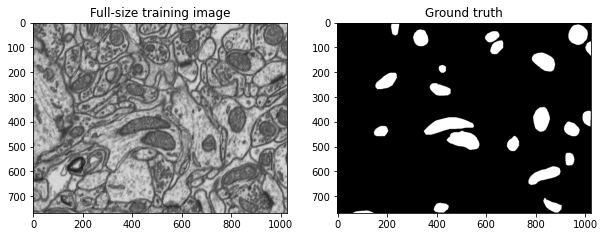

In [ ]:
from skimage.util import img_as_ubyte
from skimage import io
from matplotlib import pyplot as plt

# read training images and labels
train_img = [ img_as_ubyte( io.imread( train_input_path + '/' + x ) ) for x in train_input_filenames ]
train_lbl = [ img_as_ubyte( io.imread( train_label_path + '/' + x ) ) for x in train_label_filenames ]

# display first image
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( train_img[0], 'gray' )
plt.title( 'Full-size training image' );
# and its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_lbl[0], 'gray' )
plt.title( 'Ground truth' );

Test input images loaded: 165
Test label images loaded: 165


Text(0.5, 1.0, 'Ground truth')

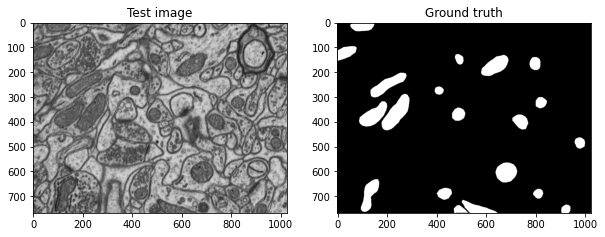

In [ ]:
# Now we load some unseen images for testing
test_input_path = 'data/test/x'
test_label_path = 'data/test/y'

# Read the list of file names
test_input_filenames = [x for x in os.listdir( test_input_path ) if x.endswith(".tif")]
test_input_filenames.sort()

test_label_filenames = [x for x in os.listdir( test_label_path ) if x.endswith(".tif")]
test_label_filenames.sort()

print( 'Test input images loaded: ' + str( len(test_input_filenames)) )
print( 'Test label images loaded: ' + str( len(test_label_filenames)) )
# Read test images
test_img = [ img_as_ubyte( io.imread( test_input_path + '/' + x ) ) for x in test_input_filenames ]
test_lbl = [ img_as_ubyte( io.imread( test_label_path + '/' + x ) ) for x in test_label_filenames ]


# Display corresponding first patch at low resolution
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow( test_img[0], 'gray' )
plt.title( 'Test image' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( test_lbl[0], 'gray' )
plt.title( 'Ground truth' )

## Preparing the training data
Now, we are going to create the training set by cropping the input images into **patches of 256 x 256 pixels**. 

This allows to use independently the patches as different images being able to apply different transformations to them, also avoiding our model to learn from position like features, as we're dealing with volumetric images, the position of the mitochondrias is preserved under consecutive slices therefore our model could easily focus on the position of the mitochondria to enhance its performance. By cropping and performing data augmentation we deal with this problem. 

And also **add noise to some of the cropped patches** to pretrain our model.


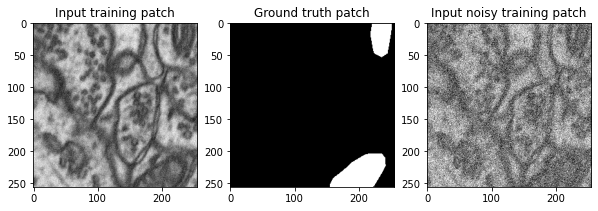

In [ ]:
import random
def create_patches( imgs, num_x_patches, num_y_patches,add_noise=False,noise_level=0):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        num_x_patches: number of patches in the X axis
        num_y_patches: number of patches in the Y axis
        add_noise: boolean to add noise to the cropped image(useful for pretraining)
        noise_level:int between 0-255 representing the sd of the gaussian noise added
        percentage_data:0-1 float specifying the percentage of data used for training
    Returns:
        list of image patches
    '''
    original_size = imgs[0].shape
    patch_width = original_size[ 0 ] // num_y_patches
    patch_height = original_size[ 1 ] // num_x_patches
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( 0, num_y_patches ):
            for j in range( 0, num_x_patches ):
              if add_noise:
                trainNoise = np.random.normal(loc=0, scale=np.random.choice(range(1,noise_level)), size=(patch_width,patch_height))
                patches.append(np.clip(image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ]+trainNoise,0,255)  )
              else:
                patches.append(image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ]  )
    
    return patches

def reduce_number_patches(patches,label_patches,percentage_data=1):
    
    n=len(patches)
    
    idx=random.sample(list(range(0,n)),int(n*percentage_data))
    x= [patches[i] for i in idx] 
    y= [label_patches[i] for i in idx] 
    print('Created list with '+str(len(x))+' patches')
    return x,y

# use method to create patches
train_img_patches = create_patches( train_img, 4, 3 )
train_lbl_patches = create_patches( train_lbl, 4, 3 )
train_img_patches_noisy = create_patches( train_img, 4, 3,add_noise=True,noise_level=50 )




# display one patch
# display first image
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow( train_img_patches[0], 'gray' )
plt.title( 'Input training patch' );
# and its "ground truth"
plt.subplot(1, 3, 2)
plt.imshow( train_lbl_patches[0], 'gray' )
plt.title( 'Ground truth patch' );

plt.subplot(1, 3, 3)
plt.imshow( train_img_patches_noisy[0], 'gray' )
plt.title( 'Input noisy training patch' );
# We will use these patches as "ground truth" for training

Now we are going to reduce the number of annotated images used for training. This is meant to simulate the case where few annotated images for training are available as they often require from expert labelling but there's available a bunch of non-annotated images. 

In [ ]:
#create 2-5-10-20-40-50% patches
train_img_patches2,train_lbl_patches2=reduce_number_patches(train_img_patches,train_lbl_patches,percentage_data=0.02)
train_img_patches5,train_lbl_patches5=reduce_number_patches(train_img_patches,train_lbl_patches,percentage_data=0.05)
train_img_patches10,train_lbl_patches10=reduce_number_patches(train_img_patches,train_lbl_patches,percentage_data=0.1)
train_img_patches20,train_lbl_patches20=reduce_number_patches(train_img_patches,train_lbl_patches,percentage_data=0.2)
train_img_patches50,train_lbl_patches50=reduce_number_patches(train_img_patches,train_lbl_patches,percentage_data=0.5)

Created list with 39 patches
Created list with 99 patches
Created list with 198 patches
Created list with 396 patches
Created list with 990 patches


## Evaluation metrics
To evaluate the segmentation performance, we will use the [Jaccard index or Intersection over the Union](https://en.wikipedia.org/wiki/Jaccard_index), after thresholding the outputs using 0.5 as threshold value:

In [ ]:
def jaccard_index(y_true, y_pred, t=0.5):
    """Define Jaccard index.
       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
            t (float, optional): threshold to be applied.
       Return:
            jac (tensor): Jaccard index value
    """

    y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)

    TP = tf.math.count_nonzero(y_pred_ * y_true)
    FP = tf.math.count_nonzero(y_pred_ * (y_true - 1))
    FN = tf.math.count_nonzero((y_pred_ - 1) * y_true)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac

## Custom loss functions
To better train our segmentation networks, we can define new loss functions based on the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) which is a proper segmentation metric:

In [ ]:
from tensorflow.keras import losses

def dice_coeff(y_true, y_pred):
    """Define Dice coefficient.
       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
       Return:
            score (tensor): Dice coefficient value
    """
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# Dice coefficient loss (1 - Dice coefficient)
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# Loss function combining binary cross entropy and Dice loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Weighted BCE+Dice
# Inspired by https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
def weighted_bce_dice_loss(w_dice=0.5, w_bce=0.5):
    def loss(y_true, y_pred):
        return losses.binary_crossentropy(y_true, y_pred) * w_bce + dice_loss(y_true, y_pred) * w_dice
    return loss

## One-cycle policy for super-convergence
We implement the learning rate on a one-cycle policy as per Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf) for fast convergence.

In [ ]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

## Network definitions
Next, we define our U-Net-like networks. In particular, we define three type of architectures:
* `MobileNetEncoder`is an encoder based in a MobileNet V2 architecture where the bottleneck would be the output of the MobileNet and 4 resolution levels in the expanding path(based in the tutorial from TF https://www.tensorflow.org/tutorials/generative/pix2pix )
* `UNet` is a regular U-Net with 4 resolution levels in the contracting path, a bottleneck, and 4 resolution levels in the expanding path.
* `ResUNet` is a residual U-Net with a user-defined depth (number of levels + bottleneck).

In [ ]:
# Network definitions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, Conv1D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Add, concatenate, Lambda

def MobileNetEncoder(input_size = (None,None,1),
         train_encoder=False,
         random_encoder_weights=True,
         output_channels=1,max_pooling=False,pre_load_weights=False,weights=None):
  """
  Create an encoder based in MobileNet attached to a general decoder for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            random_encoder_weights(bool,optional):whether to initialise the encoder's weights
               to random weights or the pretrained in the imagenet or to load previously trained ones
            Output_channels(int,optional):define the kind of segmentation(semantic) 
            and number of elements to segmentate
            max_pooling(boolean,optional):whether to apply a max_pooling or average pooling
            pre_load_weights(boolean,optional): if we want to add to our model some pretrained weights
            weights:list of numpy weights obtained from keras.get_weights
       Returns:
            model (Keras model): model containing the segmentation net created.
  """
  
    #Now we load the base MobileNetV2 architecture for the decoder
  encoder_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False,
                                                    weights=None if random_encoder_weights else 'imagenet',
                                                    pooling='max'if max_pooling else 'avg')

    # Use the activations of these layers as the skip connections(blocks 1-13) and bottleneck(block 16)
  layer_names = [
     'block_1_expand_relu',   
     'block_3_expand_relu',   
     'block_6_expand_relu',   
     'block_13_expand_relu', 
     'block_16_project',      
  ]
    #Now we select the previous layers
  layers = [encoder_model.get_layer(name).output for name in layer_names]
  
    # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=encoder_model.input, outputs=layers)
    #Here we define the number of layers for the decoder
    # The function applies a convolution to recreate the image
  up_stack = [
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),  # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
  ]

  down_stack.trainable = train_encoder
  encoder_model.trainable=train_encoder
  
  inputs = tf.keras.layers.Input(shape=input_size)
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same',activation='sigmoid')  #128x128 -> 256x256
  x = last(x)
  model= tf.keras.Model(inputs=inputs, outputs=x)
  if pre_load_weights:
    model.set_weights(weights)
  return model

  # Regular U-Net
def UNet(input_size = (None,None,1),
         filters=16,
         activation='elu',
         kernel_initializer = 'he_normal',
         dropout_value=0.2,
         average_pooling=True,
         spatial_dropout=False):
  """
  Create a U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            filters (int, optional): number of channels at the first level of U-Net
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
                initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
                level and the bottleneck
            average_pooling (bool, optional): use average-pooling between U-Net
                levels (otherwise use max pooling).
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
       Returns:
            model (Keras model): model containing the ResUNet created.
  """
  # make a list of dropout values if needed
  if type( dropout_value ) is float:
            dropout_value = [dropout_value]*5

  inputs = Input( input_size )
  # Encoder 
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  conv1 = SpatialDropout2D(dropout_value[0])(conv1) if spatial_dropout else Dropout(dropout_value[0]) (conv1)
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = AveragePooling2D(pool_size=(2, 2))(conv1) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool1)
  conv2 = SpatialDropout2D(dropout_value[1])(conv2) if spatial_dropout else Dropout(dropout_value[1]) (conv2)
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = AveragePooling2D(pool_size=(2, 2))(conv2) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool2)
  conv3 = SpatialDropout2D(dropout_value[2])(conv3) if spatial_dropout else Dropout(dropout_value[2]) (conv3)
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = AveragePooling2D(pool_size=(2, 2))(conv3) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = SpatialDropout2D(dropout_value[3])(conv4) if spatial_dropout else Dropout(dropout_value[3])(conv4)
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  pool4 = AveragePooling2D(pool_size=(2, 2))(conv4) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv4)

  # Bottleneck
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = SpatialDropout2D(dropout_value[4])(conv5) if spatial_dropout else Dropout(dropout_value[4])(conv5)
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  
  # Decoder
  up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same') (conv5)
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge6)
  conv6 = SpatialDropout2D(dropout_value[3])(conv6) if spatial_dropout else Dropout(dropout_value[3])(conv6)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same') (conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge7)
  conv7 = SpatialDropout2D(dropout_value[2])(conv7) if spatial_dropout else Dropout(dropout_value[2])(conv7)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv7)

  up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge8)
  conv8 = SpatialDropout2D(dropout_value[1])(conv8) if spatial_dropout else Dropout(dropout_value[1])(conv8)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv8)

  up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = SpatialDropout2D(dropout_value[0])(conv9) if spatial_dropout else Dropout(dropout_value[0])(conv9)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv9)

  outputs = Conv2D( input_size[2], (1, 1), activation='sigmoid') (conv9)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


# == Residual U-Net ==

def residual_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   separable_conv=False, firstBlock=False, spatial_dropout=False):

    # Create shorcut
    shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False or firstBlock:
        x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=1, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    if dropout_value:
        x = SpatialDropout2D( dropout_value ) (x) if spatial_dropout else Dropout( dropout_value ) (x)
        print( str( dropout_value ) )
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    print( 'residual block, dim: ' + str(dim) + ' , output shape: '+ str(x.shape) )
    return x

def level_block(x, depth, dim, fs, ac, k, d, bn, sc, fb, ap, spatial_dropout):
    do = d[depth] if d is not None else None
    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, do, bn, sc, fb, spatial_dropout)
        x = AveragePooling2D((2, 2)) (r) if ap else MaxPooling2D((2, 2)) (r)
        x = level_block(x, depth-1, (dim*2), fs, ac, k, d, bn, sc, False, ap, spatial_dropout) 
        x = Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    else:
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    return x


def ResUNet( input_size=(None, None, 1), activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, average_pooling=False, separable=False,
            filters=16, depth=4, spatial_dropout=False, long_shortcut=True ):

    """Create a Residual U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
            level and the bottleneck
            batchnorm (bool, optional): use batch normalization
            average_pooling (bool, optional): use average-pooling between U-Net levels 
            (otherwise use max pooling).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            filters (int, optional): number of channels at the first level of U-Net
            depth (int, optional): number of U-Net levels
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            long_shortcut (bool, optional): add long shorcut from input to output.
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input( input_size )
    if dropout_value is not None:
        if type( dropout_value ) is float:
            dropout_value = [dropout_value]*(depth+1)
        else:
            dropout_value.reverse() # reverse list to go from top to down

    x = level_block(inputs, depth, filters, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, separable, True, average_pooling,
                    spatial_dropout)

    if long_shortcut:
        x = Add()([inputs,x]) # long shortcut

    outputs = Conv2D( input_size[2], (1, 1), activation='sigmoid' ) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Implementation of Mish activation function (from https://github.com/digantamisra98/Mish/blob/master/Mish/TFKeras/mish.py):

In [ ]:
"""Tensorflow-Keras Implementation of Mish"""

## Import Necessary Modules
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

## Data augmentation
Now, we define a method to perform data augmentation over the training set.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform

# Random rotation of an image by a multiple of 90 degrees
def random_90rotation( img ):
    return transform.rotate(img, 90*np.random.randint( 0, 5 ), preserve_range=True)

# Runtime data augmentation
def get_train_val_generators(X_data, Y_data, validation_split=0.25,
                             batch_size=32, seed=42, rotation_range=0,
                             horizontal_flip=True, vertical_flip=True,
                             width_shift_range=0.0,
                             height_shift_range=0.0,
                             shear_range=0.0,
                             brightness_range=None,
                             rescale=None,
                             preprocessing_function=None,
                             show_examples=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed, shuffle=False)
    
    # Image data generator distortion options
    data_gen_args = dict( rotation_range = rotation_range,
                          width_shift_range=width_shift_range,
                          height_shift_range=height_shift_range,
                          shear_range=shear_range,
                          brightness_range=brightness_range,
                          preprocessing_function=preprocessing_function,
                          horizontal_flip=horizontal_flip,
                          vertical_flip=vertical_flip,
                          rescale = rescale,
                          fill_mode='reflect')


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Validation data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator(rescale=rescale)
    Y_datagen_val = ImageDataGenerator(rescale=rescale)
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=False, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=False, seed=seed)
    
    if show_examples:
        plt.figure(figsize=(10,10))
        # generate samples and plot
        for i in range(3):
            # define subplot
            plt.subplot(321 + 2*i)
            # generate batch of images
            batch = X_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
            plt.subplot(321 + 2*i+1)
            # generate batch of images
            batch = Y_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
        # show the figure
        plt.show()
        X_train_augmented.reset()
        Y_train_augmented.reset()
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

print("Created functions for data augmentation")

Created functions for data augmentation


## Training the network
Important training information:
*   `Validation split`: percentage of training samples used for validation. Set to a random 10%.
*   `Epochs`: which defines the maximum number of epochs the model will be trained. Initially set to 20.
*   `Patience`: number of epochs that produced the monitored quantity (validation MSE) with no improvement after which training will be stopped. Initially set to 5.
*   `Batch size`:  the number of training examples in one forward/backward pass. Initially set to 6.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,random_encoder_weights=True,preTrain=False,pre_load_weights=False,weights=None,plot_history=False):
  """Inputs:
        numEpochs(int):number of "loops" of training
        patience(int): number of "loops" without improvement till the training is stopped
        lr(float): number indicating the lr starting value
        batch_size_value(int):number of images in each step of improvement inside an epoch
        schedule(string):indicating the variations performed in the lr during the training #'oneCycle' # 'reduce' # None
        model_name(string):indicating the architecture to be used #'UNet','ResUNet','MobileNetEncoder'
        loss_acronym(string): indicating the name of the loss function to be applied 'BCE', 'Dice', 'W_BCE_Dice'
        optimizer_name(string):indicating the kind of optimized to be used 'Adam', 'SGD'
        max_pooling(boolean):indicating True if max_pooling must be performed, False if average pooling to be performed
        preTrain(boolean):indicating whether we're preTraining with denoising the network or training it for the final task
       
       
       
       
      Output:
      history
      model
  """
  #Here we establish the architecture based in the input model_name
  if model_name == 'UNet':
      model = UNet( filters=num_filters, dropout_value=dropout_value,
                   spatial_dropout=False, average_pooling=True, activation='elu' )
  elif model_name == 'ResUNet':
      model = ResUNet( filters=num_filters, batchnorm=False, spatial_dropout=True,
                      average_pooling=False, activation='elu', separable=False,
                      dropout_value=dropout_value )
  elif model_name=='MobileNetEncoder':
      model =MobileNetEncoder(
           train_encoder=train_encoder,
           random_encoder_weights=True,
           output_channels=1,
          max_pooling=True,pre_load_weights=pre_load_weights,weights=weights)
  model.summary()

  if optimizer_name == 'SGD':
      optim =  tf.keras.optimizers.SGD(
              lr=lr, momentum=0.99, decay=0.0, nesterov=False)
  elif optimizer_name == 'Adam':
      optim = tf.keras.optimizers.Adam( learning_rate=lr )

  if loss_acronym == 'BCE':
      loss_funct = 'binary_crossentropy'
  elif loss_acronym == 'Dice':
      loss_funct = dice_loss
  elif loss_acronym == 'W_BCE_Dice':
      loss_funct = weighted_bce_dice_loss(w_bce=0.8, w_dice=0.2)
  elif loss_acronym=='mse':
      loss_funct='mse'

  if preTrain:
    eval_metric = 'mean_absolute_error'
  else:
    eval_metric = jaccard_index

  # compile the model with the specific optimizer, loss function and metric
  model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

  # callback for early stop
  earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

  if schedule == 'oneCycle':
      # callback for one-cycle schedule
      steps = np.ceil(len(X_train) / batch_size_value) * numEpochs
      lr_schedule = OneCycleScheduler(lr, steps)
  elif schedule == 'reduce':
      # callback to reduce the learning rate in the plateau
     lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                               patience=patience, min_lr=(lr/10))
  else:
      lr_schedule = None

  callbacks = [earlystopper] if lr_schedule is None else [earlystopper, lr_schedule]

  # train!
  history = model.fit(train_generator, validation_data=val_generator,
                      validation_steps=np.ceil(len(X_train)*0.1/batch_size_value),
                      steps_per_epoch=np.ceil(len(X_train)/batch_size_value),
                      epochs=numEpochs, callbacks=callbacks)
  import matplotlib.pyplot as plt
  if plot_history:
    plt.figure(figsize=(14,5))

    if callable( eval_metric ):
     metric_name = eval_metric.__name__
    else:
      metric_name = eval_metric

    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_'+metric_name])
    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

  return history,model

###Pretraining - Denoising
The idea is to **pretrain the network by using the noisy patches** previously created as the input and the **pretraining ground_truth would be the original images**. 

This procedure is meant to **enhance the initial weights of our model to afterwards improve its segmentation performance** or at least to reduce the number of images needed.

As loss function, we use the mean squared error (MSE) between the expected and the predicted pixel values, and we also include the mean absolute error (MAE) as a control metric.

For this step **we will use all the training data**, as even simulating scarcity of labelled data, the unlabelled data might still be available for being used in SSL denoising.

In [ ]:
# Prepare the training data and create data generators
import numpy as np
batch_size_value=1
# training input
X_train = np.asarray(train_img_patches_noisy, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_img_patches, dtype=np.float32)#here we define our ground_truth
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

(256, 256, 1)
(256, 256, 1)


In [ ]:
# === PreTraining parameters ===
# number of epochs
numEpochs = 20
# patience
patience = 3
# learning rate
lr = 5e-4
# batch size
batch_size_value = 1
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'oneCycle' #'oneCycle' # 'reduce' # None
# Network architecture: UNet, ResUNet,MobileNetEncoder
model_name = 'MobileNetEncoder'
# Optimizer name: 'Adam', 'SGD'
optimizer_name = 'Adam'
# Loss function name: 'BCE', 'Dice', 'W_BCE_Dice'
loss_acronym = 'mse'
max_pooling=True
history,model=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,preTrain=True)
print('Pre-trained weights are ready to be used!')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841408     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 1 0           sequential[0][0]                 
                                                                 model[0][3]                

Now it would be interesting to visualize our output data to check what does the output of our net look like. 


# Generate predictions for 3 samples
predictions shape: (3, 256, 256, 1)


Text(0.5, 1.0, 'Denoised image')

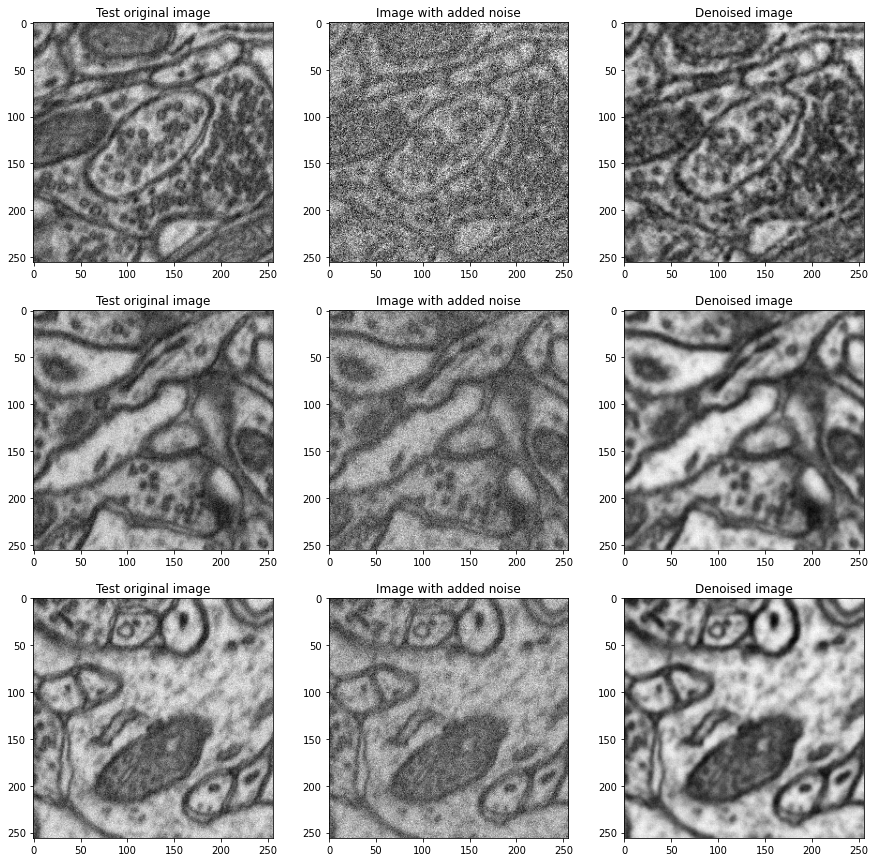

In [ ]:
test_img_patches_noisy = create_patches( test_img, 4, 3,add_noise=True,noise_level=50 )
test_img_patches = create_patches( test_img, 4, 3,add_noise=False )

# Evaluate trained network on test images
X_test = [x/255 for x in test_img_patches_noisy] # normalize between 0 and 1
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.expand_dims( X_test, axis=-1 )

Y_test = [x/255 for x in test_img_patches] # normalize between 0 and 1
Y_test = np.asarray(Y_test, dtype=np.float32)
Y_test = np.expand_dims( Y_test, axis=-1 )


print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)
# Display corresponding first 3 patches
plt.figure(figsize=(15,15))
plt.subplot(3, 3, 1)
plt.imshow( test_img_patches[0], 'gray' )
plt.title( 'Test original image' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 2)
plt.imshow( test_img_patches_noisy[0], 'gray' )
plt.title( 'Image with added noise' )
# and its prediction
plt.subplot(3, 3, 3)
plt.imshow( predictions[0,:,:,0], cmap='gray' )
plt.title( 'Denoised image' )

plt.subplot(3, 3, 4)
plt.imshow( test_img_patches[1], 'gray' )
plt.title( 'Test original image' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 5)
plt.imshow( test_img_patches_noisy[1], 'gray' )
plt.title( 'Image with added noise' )
# and its prediction
plt.subplot(3, 3, 6)
plt.imshow( predictions[1,:,:,0], cmap= 'gray' )
plt.title( 'Denoised image' )

plt.subplot(3, 3, 7)
plt.imshow( test_img_patches[2], 'gray' )
plt.title( 'Test original image' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 8)
plt.imshow( test_img_patches_noisy[2], 'gray' )
plt.title( 'Image with added noise' )
# and its prediction
plt.subplot(3, 3, 9)
plt.imshow( predictions[2,:,:,0], cmap= 'gray' )
plt.title( 'Denoised image' )

### Prepare data for training
Now in order to prepare the training for the real task we'll take again the images but this time:

* **Our inputs are the original patches** with no noise
* And the **groundtruth would be the already labelled patches** 

### Choose the network's architecture, loss function and train



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# === Training parameters ===
# number of epochs
numEpochs = 60
# patience
patience = 20#this means that the net won't be stopped before 30 epochs
# learning rate
lr = 5e-4
# batch size
batch_size_value = 1
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'oneCycle' #'oneCycle' # 'reduce' # None
# Network architecture: UNet, ResUNet,MobileNetEncoder
model_name = 'MobileNetEncoder'
# Optimizer name: 'Adam', 'SGD'
optimizer_name = 'Adam'
# Loss function name: 'BCE', 'Dice', 'W_BCE_Dice'
loss_acronym = 'BCE'
# create the network and compile it with its optimizer
max_pooling=True
#now we should extract the pretrained weights in denoising from the model
weights = model.get_weights()

### Training with 100% labels


In [ ]:

# training input
X_train = np.asarray(train_img_patches, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

(256, 256, 1)
(256, 256, 1)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            [(None, None, None,  1841408     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, None, None, 5 1476608     model_2[0][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, None, None, 1 0           sequential_4[0][0]               
                                                                 model_2[0][3]              

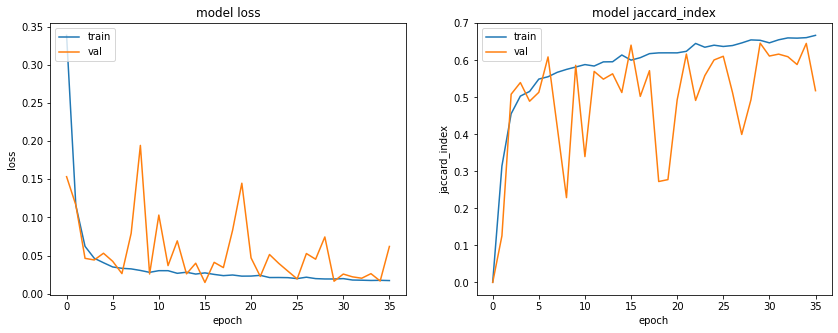

In [ ]:
history,model100=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

### Training with 2% labels

(256, 256, 1)
(256, 256, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_4 (Functional)            [(None, None, None,  1841408     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, None, None, 5 1476608     model_4[0][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, None, None, 1 0           sequential_8[0][0]               
                                                                

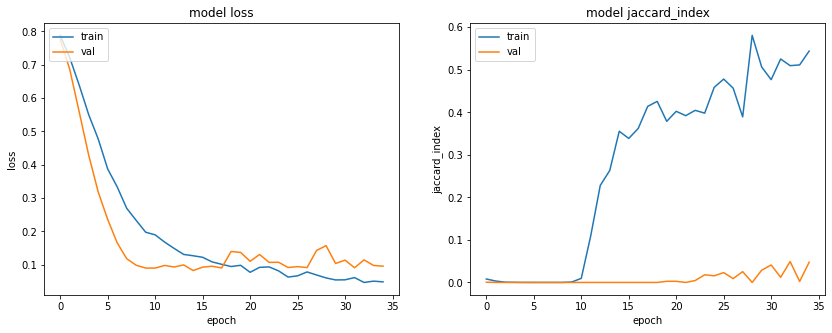

In [ ]:

# training input
X_train = np.asarray(train_img_patches2, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches2, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

history,model2=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

### Training with 5% labels

(256, 256, 1)
(256, 256, 1)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_6 (Functional)            [(None, None, None,  1841408     input_8[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, None, None, 5 1476608     model_6[0][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, None, None, 1 0           sequential_12[0][0]              
                                                                

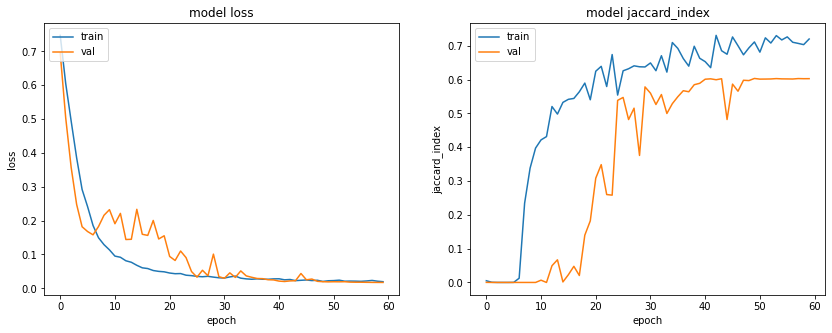

In [ ]:

# training input
X_train = np.asarray(train_img_patches5, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches5, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

history,model5=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

###Training with 10% labels

(256, 256, 1)
(256, 256, 1)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_8 (Functional)            [(None, None, None,  1841408     input_10[0][0]                   
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, None, None, 5 1476608     model_8[0][4]                    
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, None, None, 1 0           sequential_16[0][0]              
                                                                

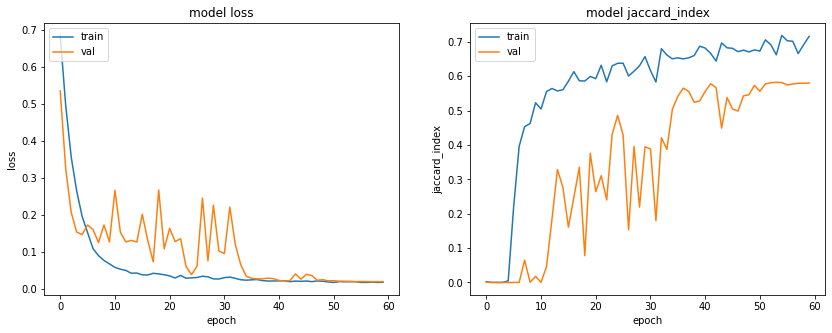

In [ ]:

# training input
X_train = np.asarray(train_img_patches10, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches10, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

history,model10=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

### Training with 25% labels

(256, 256, 1)
(256, 256, 1)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_10 (Functional)           [(None, None, None,  1841408     input_12[0][0]                   
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, None, None, 5 1476608     model_10[0][4]                   
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, None, None, 1 0           sequential_20[0][0]              
                                                               

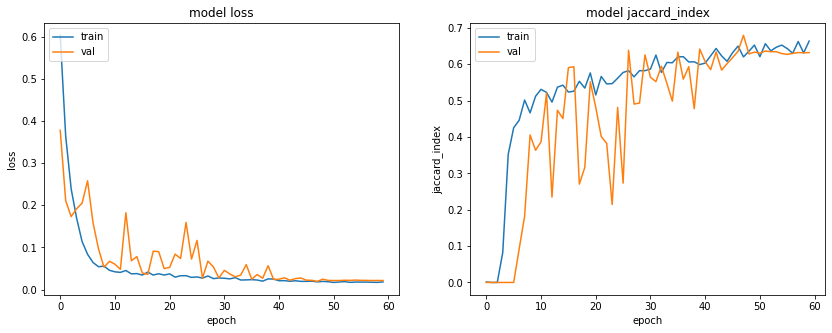

In [ ]:

# training input
X_train = np.asarray(train_img_patches20, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches20, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

history,model20=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

### Training with 50% labels

(256, 256, 1)
(256, 256, 1)
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_12 (Functional)           [(None, None, None,  1841408     input_14[0][0]                   
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, None, None, 5 1476608     model_12[0][4]                   
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, None, None, 1 0           sequential_24[0][0]              
                                                               

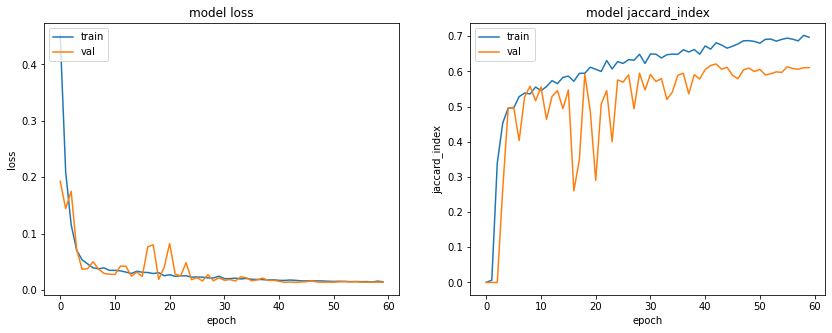

In [ ]:

# training input
X_train = np.asarray(train_img_patches50, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 ) # add extra dimension
print(X_train[0].shape)

# training ground truth
Y_train = np.asarray(train_lbl_patches50, dtype=np.float32)
Y_train = np.expand_dims( Y_train, axis=-1 ) # add extra dimension
print(Y_train[0].shape)

# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          rescale= 1./255,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

history,model50=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=True,weights=weights,plot_history=True)

In [ ]:
# Save weights for future reuse
#if schedule is None:
 #   schedule = 'None'
#weights_filename = 'drive/My Drive/mitochondria-segmentation/models/weights-' + model_name+'-nf-'+str(num_filters)+'-'+loss_acronym+'-bs-'+str(batch_size_value)+'-'+optimizer_name+'-'+schedule+'.h5'
#model.save_weights( weights_filename )
#print( 'Saved model as ' + weights_filename )

## Check performance in the test set
Finally we can load some test images for testing. Since we used `(None, None, 1)` as input size and it is a fully convolutional network, we can now pass image of any size. Therefore, there is no need to create test patches.

We can evaluate the network performance in test using the previously specified loss and metrics.


In [ ]:
# Evaluate trained network on test images
X_test = [x/255 for x in test_img] # normalize between 0 and 1
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.expand_dims( X_test, axis=-1 )

Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
Y_test = np.asarray(Y_test, dtype=np.float32)
Y_test = np.expand_dims( Y_test, axis=-1 )

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data with all training data')
results100 = model100.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results100)

print('\n# Evaluate on test data with 2% training data')
results2= model2.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results2)
print('\n# Evaluate on test data with 5% training data')
results5= model5.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results5)
print('\n# Evaluate on test data with 10% training data')
results10= model10.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results10)

print('\n# Evaluate on test data with 20% training data')
results20 = model20.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results20)

print('\n# Evaluate on test data with 50% training data')
results50 = model50.evaluate(X_test, Y_test , batch_size=batch_size_value)
print('test loss, test metric:', results50)



# Evaluate on test data with all training data
165/165 [==============================] - 5s 21ms/step - loss: 0.0256 - jaccard_index: 0.8471
test loss, test metric: [0.025639504194259644, 0.8470706939697266]

# Evaluate on test data with 2% training data
165/165 [==============================] - 5s 21ms/step - loss: 0.1723 - jaccard_index: 0.0000e+00
test loss, test metric: [0.17233678698539734, 0.0]

# Evaluate on test data with 5% training data
165/165 [==============================] - 4s 21ms/step - loss: 0.0268 - jaccard_index: 0.8351
test loss, test metric: [0.026788607239723206, 0.8350920677185059]

# Evaluate on test data with 10% training data
165/165 [==============================] - 4s 21ms/step - loss: 0.0254 - jaccard_index: 0.8445
test loss, test metric: [0.025396157056093216, 0.8445117473602295]

# Evaluate on test data with 20% training data
165/165 [==============================] - 4s 21ms/step - loss: 0.0204 - jaccard_index: 0.8704
test loss, test metric: [0.0203

And also display some images for qualitative evaluation.


 Generate predictions for all models


Text(0.5, 1.0, 'Prediction with 50% training \nIoU:0.8752003312110901')

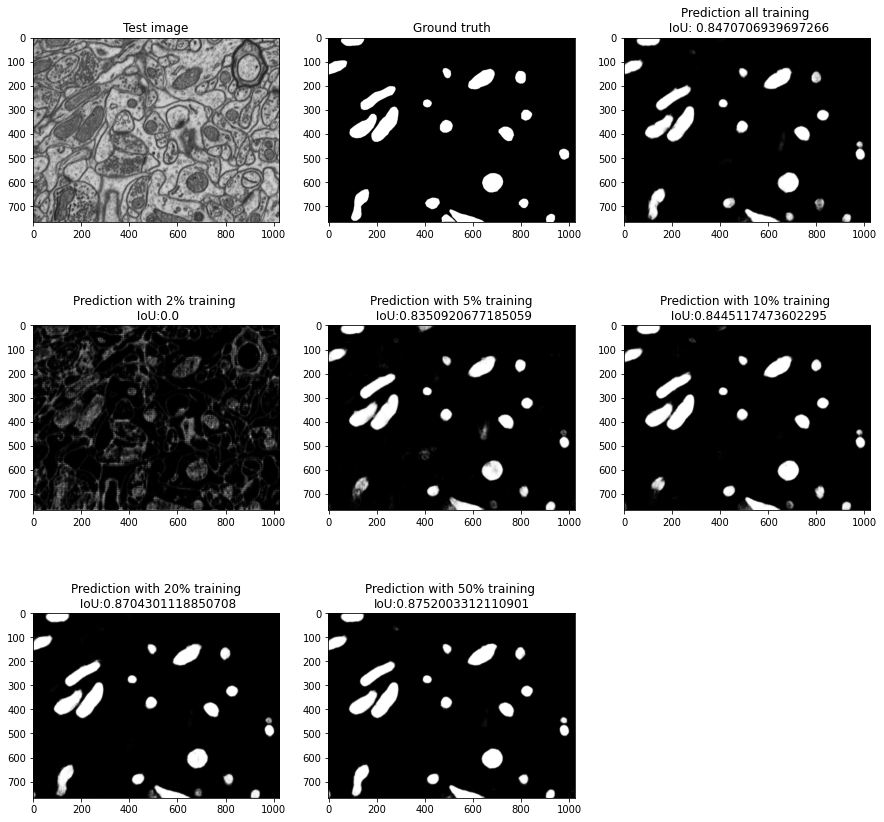

In [ ]:
print('\n Generate predictions for all models')

predictions2 = model2.predict(X_test[:3])
predictions5 = model5.predict(X_test[:3])
predictions10 = model10.predict(X_test[:3])
predictions20 = model20.predict(X_test[:3])
predictions50 = model50.predict(X_test[:3])
predictions100 = model100.predict(X_test[:3])

# Display corresponding first 3 patches
plt.figure(figsize=(15,15))
plt.subplot(3, 3, 1)
plt.imshow( test_img[0], 'gray' )
plt.title( 'Test image' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 2)
plt.imshow( test_lbl[0], 'gray' )
plt.title( 'Ground truth' )
# prediction for the model trained with 100% data
plt.subplot(3, 3, 3)
plt.imshow( predictions100[0,:,:,0], cmap='gray' )
plt.title( 'Prediction all training \n IoU: '+str(results100[1]) )
# prediction for the model trained with 2% data
plt.subplot(3, 3, 4)
plt.imshow( predictions2[0,:,:,0], cmap= 'gray' )
plt.title( 'Prediction with 2% training \n IoU:'+str(results2[1]))
# prediction for the model trained with 5% data
plt.subplot(3, 3, 5)
plt.imshow( predictions5[0,:,:,0], cmap= 'gray' )
plt.title( 'Prediction with 5% training\n IoU:'+str(results5[1]))
# prediction for the model trained with 10% data
plt.subplot(3, 3, 6)
plt.imshow( predictions10[0,:,:,0], cmap= 'gray' )
plt.title( 'Prediction with 10% training \n IoU:'+str(results10[1]))
# prediction for the model trained with 20% data
plt.subplot(3, 3, 7)
plt.imshow( predictions20[0,:,:,0], cmap= 'gray' )
plt.title( 'Prediction with 20% training\n IoU:'+str(results20[1]))
# prediction for the model trained with 50% data
plt.subplot(3, 3, 8)
plt.imshow( predictions50[0,:,:,0], cmap= 'gray' )
plt.title( 'Prediction with 50% training \nIoU:'+str(results50[1]))

